# Heavy top - polynomial approximation of degree $2 = j := \text{deg } q$, with $v = \dot{q}$

see thesis -> Numerical experiments -> Degree $j = 2$ -> Version 1: $v = \dot{q}$

This notebook also includes the energy conservation benchmark for $j = 2$, $v = \dot{q}$.

In [1]:
import ngsolve
if ngsolve.__version__ < "6.2.2405-28": 
    raise Exception("NGSolve too old, pls run 'pip3 install --upgrade --pre ngsolve'")

In [2]:
from ngsolve import *
from netgen.occ import *
import ipywidgets as widgets
from ngsolve.comp import GlobalSpace
from ngsolve.webgui import Draw
from ngsolve.solvers import Newton
from ngsolve.comp import DifferentialSymbol
import numpy as np

## System parameter setup

In [3]:
mass = 15
Jxx = Jzz = 0.234375
Jyy = 0.468750
omega0 = CF( (0,150,-4.61538) )

In [4]:
b = sqrt(3/2 * Jyy/mass)
rho = mass/(4*b*b)     # kg/ m**2

In [5]:
center = Pnt( (0,1,0) )
disk = WorkPlane(Axes((0,1,0), Y)).RectangleC(2*b, 2*b).Face()
shape = Glue ([disk, Segment( (0,0,0), (0,1,0)) ])
shape.vertices.Min(Y).name="A"
mesh = Mesh(OCCGeometry(shape).GenerateMesh(maxh=3))
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

## Finite element space setup

In [6]:
# tangent space representation
RBshapes = CF ( ( 1, 0, 0,
                  0, 1, 0,
                  0, 0, 1,
                  y, -x, 0,
                  0, z, -y,
                  -z, 0, x) ).Reshape((6,3)).Compile() # realcompile=True, wait=True)
RBspace = GlobalSpace (mesh, order=1, basis = RBshapes)

# basis of (equivalent to) symmetric matrices
SYMshapes = CF ( ( 1, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 1, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 1,
                   0, 1, 0, 1, 0, 0, 0, 0, 0,
                   0, 0, 1, 0, 0, 0, 1, 0, 0,
                   0, 0, 0, 0, 0, 1, 0, 1, 0) ).Reshape((6,9)).Compile() # realcompile=True, wait=True)
SYMspace = GlobalSpace (mesh, order=1, basis = SYMshapes)

# position space
P1shapes = CF ( ( 1, 0, 0,
                  0, 1, 0,
                  0, 0, 1,
                  x, 0, 0,
                  0, x, 0,
                  0, 0, x,
                  y, 0, 0,
                  0, y, 0,
                  0, 0, y,
                  z, 0, 0,
                  0, z, 0,
                  0, 0, z)).Reshape((12,3)).Compile() # realcompile=True, wait=True)
P1space = GlobalSpace (mesh, order=1, basis = P1shapes)
P1space.AddOperator("dx", VOL, P1shapes.Diff(x))
P1space.AddOperator("dy", VOL, P1shapes.Diff(y))
P1space.AddOperator("dz", VOL, P1shapes.Diff(z))

def MyGrad(gf):
    return CF( (gf.Operator("dx"), gf.Operator("dy"), gf.Operator("dz") )).Reshape((3,3)).trans
def MyGradB(gf):
    return CF( (gf.Operator("dx", BND), gf.Operator("dy", BND), gf.Operator("dz", BND))).Reshape((3,3)).trans
def MyGradBB(gf):
    return CF( (gf.Operator("dx", BBBND), gf.Operator("dy", BBBND), gf.Operator("dz", BBBND))).Reshape((3,3)).trans
              

In [7]:
fesR = NumberSpace(mesh)

fes = P1space * P1space * RBspace * RBspace * RBspace * fesR**3 * fesR**3 * fesR**3
festest = RBspace * RBspace * RBspace * RBspace * RBspace * SYMspace * SYMspace * fesR**3 * fesR**3 * fesR**3

gfold = GridFunction(fes)
gf = GridFunction(fes)


qhalfold, qold, phatold, voldold, vnewold, lambdahalfold, lambdanewold, muold = gfold.components
gfqhalf, gfqnew, gfphatnew, gfvold, gfvnew, gflambdahalf, gflambdanew, gfmu = gf.components

qhalf, qnew, phatnew, vold, vnew, lambdahalf, lambdanew, mu = fes.TrialFunction()
dpold, dpnew, dqold, dqhalf, dqnew, drothalf, drotnew, dlambdahalf, dlambdanew, dmu = festest.TestFunction()

dvert = DifferentialSymbol(BBBND)

In [8]:
# derivative of a quadratic polynomial given in Lagrange basis
def quadratic_deriv(oldval, midval, newval, oldt, tau, t):
    return (oldval * 2 * (2*t - (2*oldt + 1.5*tau))
            - midval * 4 * (2*t - (2*oldt + tau))
            + newval * 2 * (2*t - (2*oldt + 0.5*tau)))/(tau**2)
    

## The equations

In [9]:
force = CF( (0,0,-9.81*rho) )
P0 = CF( (0, 0, 0) )

t = 0

qold.Set ( (x, y, z) )
gfphatnew.Set ( rho*Cross (omega0, CF((x,y,z))) , definedon=mesh.Boundaries(".*") )

# time step size
tau = 0.004 * 2**(-2)

# rotational part of q at different points in time
Rnew = MyGrad(qnew)
Rhalf = MyGrad(qhalf)
Rold = MyGrad(qold)


a = BilinearForm(trialspace=fes, testspace=festest)


# What follows are the time stepper equations.

# helper equations: dot q = v
a += (1/6*(quadratic_deriv(qold, qhalf, qnew, t, tau, t) - Rold*vold) * (Rold*dpold)).Compile(realcompile=True, wait=True) * ds
a += (1/6*(quadratic_deriv(qold, qhalf, qnew, t, tau, t+tau) - Rnew*vnew) * (Rnew*dpnew)).Compile(realcompile=True, wait=True) * ds

# helper equations: p = rho*v
pold = rho*vold
pnew = rho*vnew

# δq: dot p = f
phalf = (pnew + pold)/2
a += ((tau/6 * (force - (Rnew*pnew - Rold*pold)/tau) - Rold*(pold - phatold)) * (Rold * dqold)) * ds
a += ((force - (Rnew*pnew - Rold*pold)/tau) * (Rhalf*dqhalf)) * ds
a += ((tau/6 * (force - (Rnew*pnew - Rold*pold)/tau) + Rnew*(pnew - phatnew)) * (Rnew * dqnew)) * ds
# forces from Lagrange parameters, in t_n and t_{n+t}:
a += ( (tau/6*lambdanew ) * (Rnew*dqnew)) *dvert("A")
a += ( lambdahalf * (Rhalf*dqhalf)) *dvert("A")
a += ( (tau/6*mu ) * (MyGradBB(qold)*dqold)) *dvert("A")

# constraints and velocity constraints:
a += ((qnew-P0)*dlambdanew) * dvert("A")
a += ((qhalf-P0)*dlambdahalf) * dvert("A")
a += ((phatnew)*dmu) * dvert("A")

# linear part of q is orthogonal:
a += InnerProduct (Rhalf.trans*Rhalf-Id(3), drothalf) * ds
a += InnerProduct (Rnew.trans*Rnew-Id(3), drotnew) * ds


In [10]:
def init_values():
    # tricky to set initial conditions, since mass matrix alone is singular 
    gf.vec[:] = 0
    gfold.vec[:] = 0
    qold.Set ( (x, y, z) )
    gfphatnew.Set ( rho*Cross (omega0, CF((x,y,z))) , definedon=mesh.Boundaries(".*") )
    
    qs,dqs = P1space.TnT()
    bfset = BilinearForm(qs*dqs*ds + qs.Operator("dy")*dqs.Operator("dy")*ds).Assemble()
    lfset = LinearForm(CF((x,y,z))*dqs*ds + CF((0,1,0))*dqs.Operator("dy")*ds).Assemble()
    gfqhalf.vec[:] = bfset.mat.Inverse()*lfset.vec
    gfqnew.vec[:] = bfset.mat.Inverse()*lfset.vec

In [11]:
scene = Draw (gf.components[1], mesh, deformation=(gf.components[0]-CF((x,y,z))), center=(0,0,0), radius=1.2)

tw = widgets.HTML(value='t = 0')
progress = widgets.HTML(value="")
display(widgets.VBox([tw, progress]))

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

In [12]:
init_values()
t = 0
tt = []
Epott = []
Ekint = []
Et = []
axt, ayt, azt = [], [], []
while t < 1-1e-10:
    gfold.vec[:] = gf.vec
    Newton(a=a, u=gf, printing=False, maxerr=1e-8)
    scene.Redraw()
    t += tau
    tw.value = F"<b> t = { t:.2f} </b>"
    Epot = -Integrate (gfqnew*force*ds, mesh)
    Ekin = Integrate (rho/2*gfvnew*gfvnew*ds, mesh)
    tt.append(t)
    Epott.append(Epot)
    Ekint.append(Ekin)
    axt.append (Integrate(gfqnew[0]*ds, mesh)/(4*b**2))
    ayt.append (Integrate(gfqnew[1]*ds, mesh)/(4*b**2))
    azt.append (Integrate(gfqnew[2]*ds, mesh)/(4*b**2))
    Et.append(Epot+Ekin)

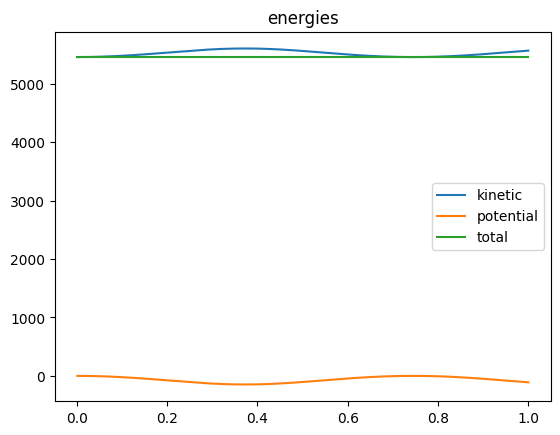

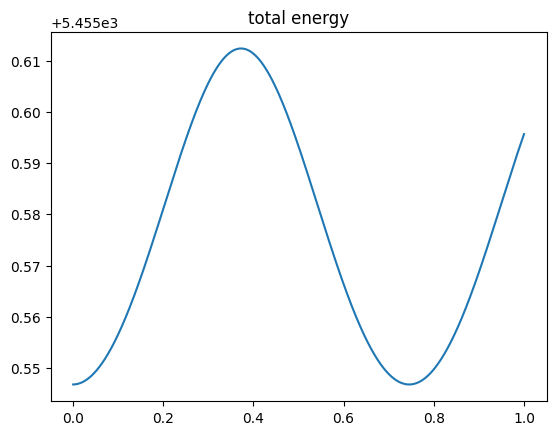

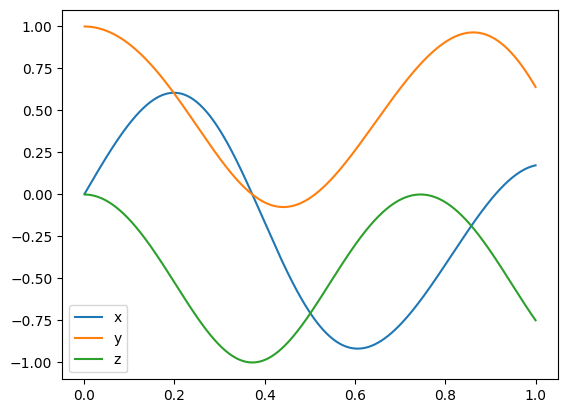

0.1733446915374599 0.6400931326360865 -0.7484867396740549


In [13]:
import matplotlib.pyplot as plt
plt.plot (tt, Ekint, label="kinetic")
plt.plot (tt, Epott, label="potential")
plt.plot (tt, Et, label="total")
plt.legend()
plt.title("energies")
plt.show()

plt.plot (tt, Et)
plt.title("total energy")
plt.show()

plt.plot (tt, axt, label="x")
plt.plot (tt, ayt, label="y")
plt.plot (tt, azt, label="z")
plt.legend()
plt.show()

print (axt[-1], ayt[-1], azt[-1])
